## ResNet Model

In [1]:
import keras
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPooling2D, Add, Flatten, Dense, Dropout
from keras.layers import Activation, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, Add, Flatten, Dense, Dropout
from keras.layers import Activation, BatchNormalization, AveragePooling2D


In [3]:
# define hyperparameters
batch_size = 128
epochs = 50
num_classes = 10

# load dataset
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# convert class vectors to binary class matrices
y_train_all = keras.utils.to_categorical(y_train_all, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
# normalize data
x_train_all = x_train_all.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# split data into training, validation and testing sets
val_ratio = 0.1
test_ratio = 0.1
num_val_samples = int(val_ratio * x_train_all.shape[0])
num_test_samples = int(test_ratio * x_train_all.shape[0])


x_val = x_train_all[num_test_samples:num_test_samples+num_val_samples]
y_val = y_train_all[num_test_samples:num_test_samples+num_val_samples]
x_train = x_train_all[num_test_samples+num_val_samples:]
y_train = y_train_all[num_test_samples+num_val_samples:]

In [5]:
# define the ResNet architecture
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    if conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', 
                          use_bias=False)(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', 
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', 
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [6]:
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters = 64
    for i in range(3):
        x = residual_block(x, filters, conv_shortcut=True if i == 0 else False)
    filters *= 2
    for i in range(4):
        x = residual_block(x, filters, conv_shortcut=True if i == 0 else False)
    filters *= 2
    for i in range(6):
        x = residual_block(x, filters, conv_shortcut=True if i == 0 else False)
    
    x = AveragePooling2D(pool_size=7)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [7]:
input_shape = x_train.shape[1:]
model = resnet(input_shape, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9408        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [8]:
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
optimizer=optimizer,
metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
datagen_train = ImageDataGenerator(
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True,
fill_mode='nearest')

datagen_train.fit(x_train)

In [10]:
history = model.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size),
steps_per_epoch=len(x_train) / batch_size,
epochs=epochs,
validation_data=(x_val, y_val),
verbose=1)

Epoch 1/50
312/312 [==============================] - 29s 76ms/step - loss: 1.5831 - accuracy: 0.4423 - val_loss: 2.3939 - val_accuracy: 0.2628
Epoch 2/50
312/312 [==============================] - 20s 64ms/step - loss: 1.1809 - accuracy: 0.5816 - val_loss: 2.8911 - val_accuracy: 0.3492
Epoch 3/50
312/312 [==============================] - 20s 63ms/step - loss: 0.9956 - accuracy: 0.6497 - val_loss: 2.2074 - val_accuracy: 0.4442
Epoch 4/50
312/312 [==============================] - 20s 65ms/step - loss: 0.8747 - accuracy: 0.6926 - val_loss: 1.1842 - val_accuracy: 0.5888
Epoch 5/50
312/312 [==============================] - 20s 63ms/step - loss: 0.8079 - accuracy: 0.7188 - val_loss: 0.8403 - val_accuracy: 0.6960
Epoch 6/50
312/312 [==============================] - 20s 62ms/step - loss: 0.7387 - accuracy: 0.7413 - val_loss: 1.1716 - val_accuracy: 0.6122
Epoch 7/50
312/312 [==============================] - 20s 63ms/step - loss: 0.6945 - accuracy: 0.7582 - val_loss: 1.1770 - val_accuracy:

In [11]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.7243 - accuracy: 0.8225
Test loss: 0.7243140339851379
Test accuracy: 0.8224999904632568


313/313 [==============================] - 2s 4ms/step


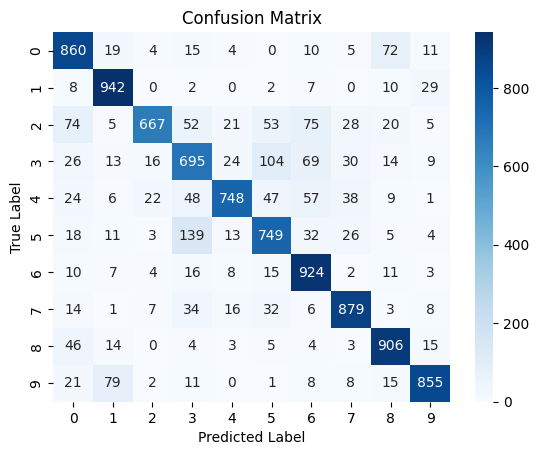

              precision    recall  f1-score   support

    airplane       0.78      0.86      0.82      1000
  automobile       0.86      0.94      0.90      1000
        bird       0.92      0.67      0.77      1000
         cat       0.68      0.69      0.69      1000
        deer       0.89      0.75      0.81      1000
         dog       0.74      0.75      0.75      1000
        frog       0.78      0.92      0.84      1000
       horse       0.86      0.88      0.87      1000
        ship       0.85      0.91      0.88      1000
       truck       0.91      0.85      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [12]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, 
                           target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 
                                         'dog', 'frog', 'horse', 'ship', 'truck'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(cr)

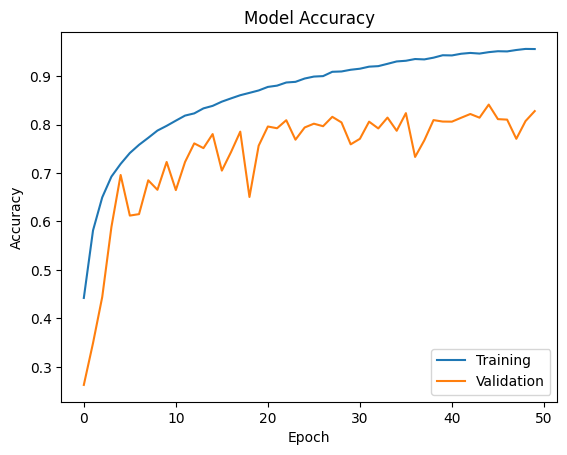

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

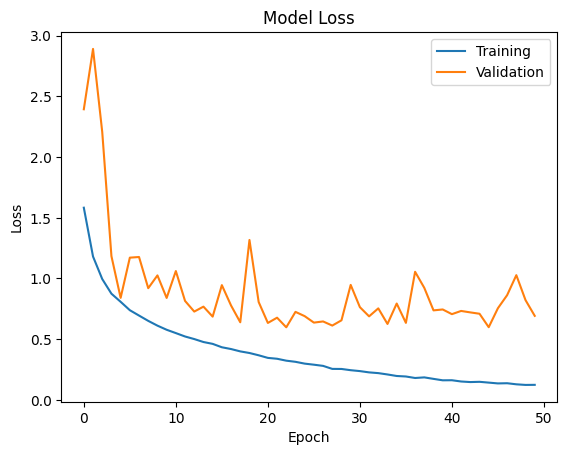

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()